# Preprocessing And Cleaning

In [97]:
import pandas as pd
df=pd.read_csv("bengaluru_house_prices.csv")
print(df.head())
# Check shape and column names
print("Shape:", df.shape)
print("Columns:", df.columns)

# Summary of data types and missing values
print(df.info())

# Count of missing values
print(df.isnull().sum())
# Check unique values in 'society' and 'availability'
print(df['society'].nunique())  # likely many missing or useless
print(df['availability'].unique())

# Drop 'society', 'availability', 'balcony' (if needed)
df = df.drop(['society', 'availability'], axis=1)
# Drop rows with too many nulls
df = df.dropna()

# Check again
df.isnull().sum()
# Example: '2 BHK' -> 2
df['BHK'] = df['size'].apply(lambda x: int(x.split(' ')[0]) if isinstance(x, str) else None)

# Drop original size column
df = df.drop(['size'], axis=1)
def convert_sqft(x):
    try:
        if '-' in x:
            nums = x.split('-')
            return (float(nums[0]) + float(nums[1])) / 2
        return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft)
df = df[df['total_sqft'].notnull()]
print(df['price'].head())  # Already numeric, no need to convert
df.to_csv("cleaned_bengaluru_house_data.csv", index=False)

              area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00  
Shape: (13320, 9)
Columns: Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
D

# EDA

In [98]:
import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
df=pd.read_csv("cleaned_bengaluru_house_data.csv")

In [100]:
df.describe()

,total_sqft,bath,balcony,price,BHK
count,12668.000000,12668.000000,12668.000000,12668.000000,12668.000000
mean,1511.835167,2.616277,1.585649,105.952648,2.736422
std,1162.097276,1.223882,0.816758,131.813137,1.202643
min,5.000000,1.000000,0.000000,8.000000,1.000000
25%,1100.000000,2.000000,1.000000,49.015000,2.000000
50%,1260.000000,2.000000,2.000000,70.000000,3.000000
75%,1640.000000,3.000000,2.000000,115.000000,3.000000
max,52272.000000,40.000000,3.000000,2912.000000,43.000000


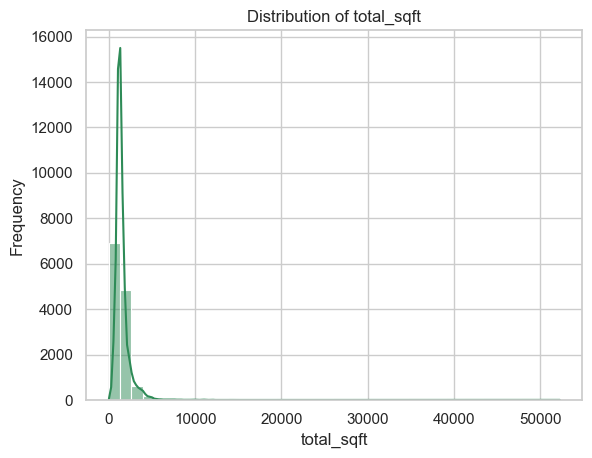

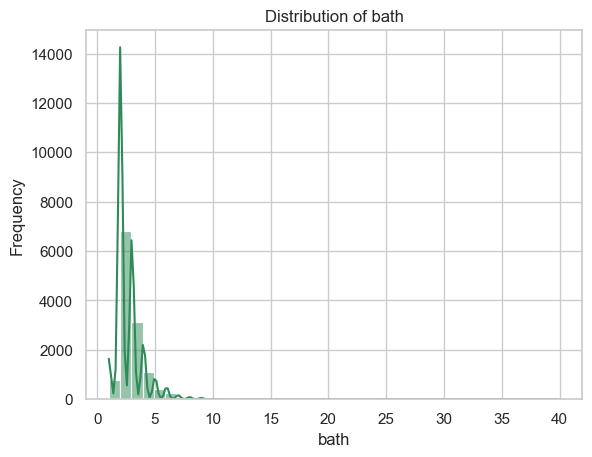

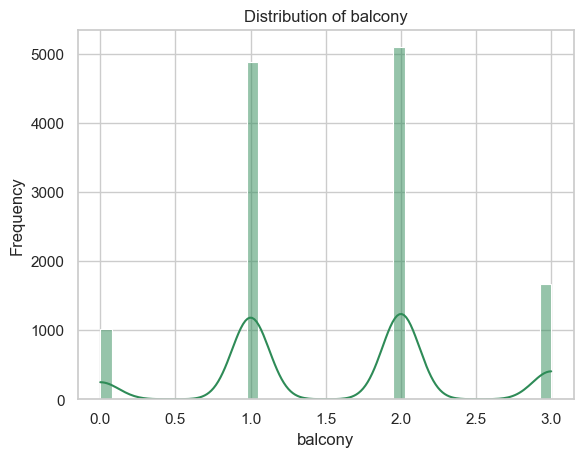

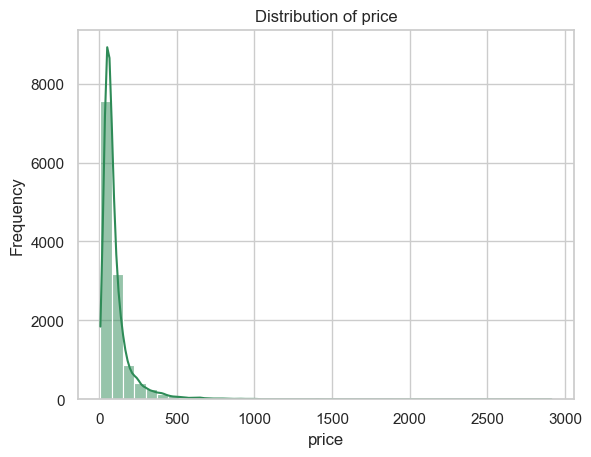

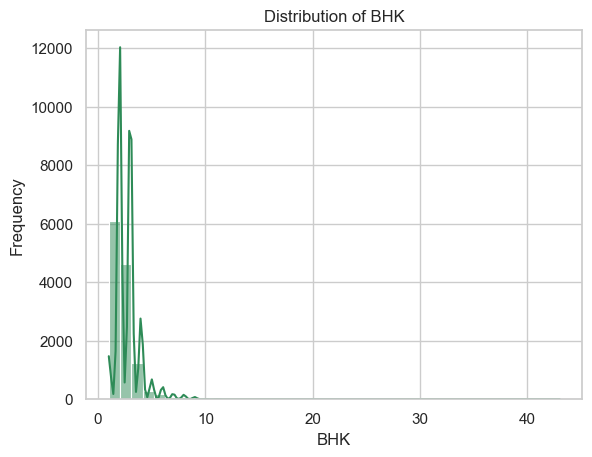

In [101]:

features = ['total_sqft', 'bath', 'balcony', 'price', 'BHK']

for feature in features:
    sns.set_style('whitegrid')
    sns.histplot(x=feature,data=df, bins=40, kde=True, color='seagreen')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()
  


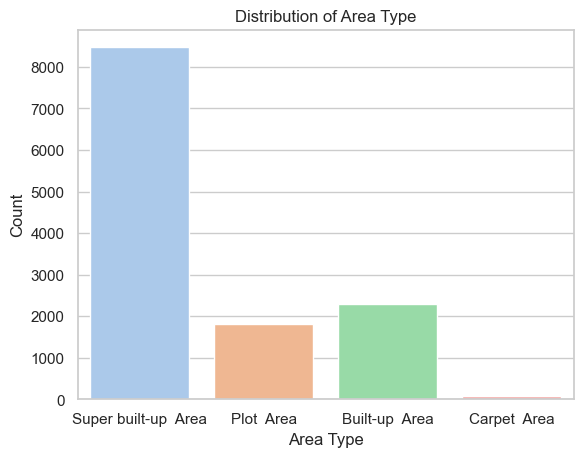

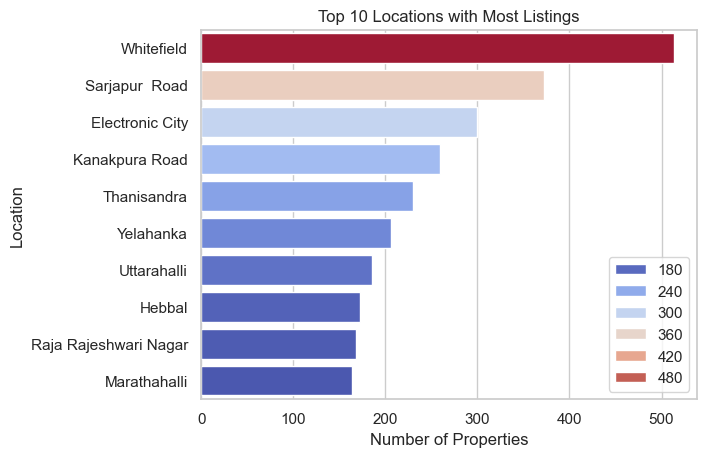

In [102]:
sns.countplot(data=df, x='area_type', hue='area_type',palette='pastel')
plt.title('Distribution of Area Type')
plt.xlabel('Area Type')
plt.ylabel('Count')
plt.show()


top_locations = df['location'].value_counts().nlargest(10)

sns.barplot(x=top_locations.values, y=top_locations.index,hue=top_locations.values, palette='coolwarm')
plt.title('Top 10 Locations with Most Listings')
plt.xlabel('Number of Properties')
plt.ylabel('Location')
plt.show()


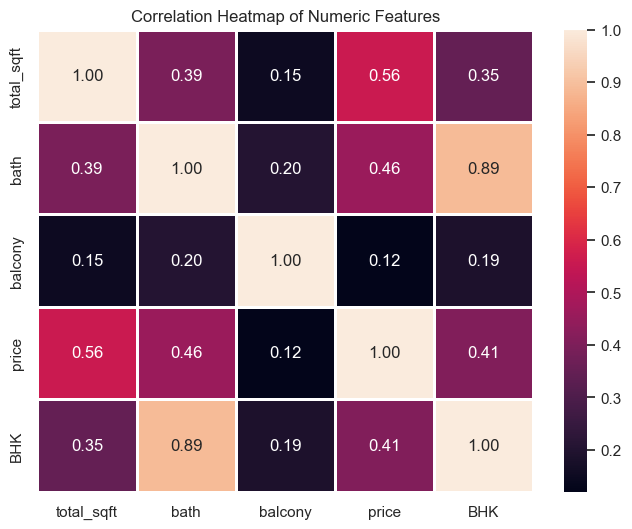

In [103]:
corr_matrix = df[features].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", linewidths=1)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

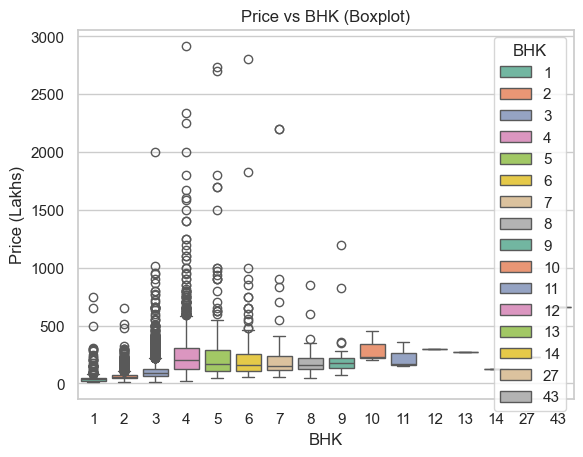

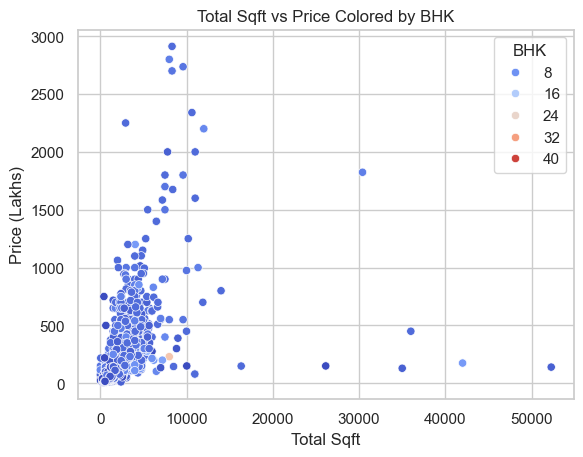

In [104]:
sns.boxplot(data=df, x='BHK', y='price',hue='BHK',palette='Set2')
plt.title('Price vs BHK (Boxplot)')
plt.xlabel('BHK')
plt.ylabel('Price (Lakhs)')
plt.show()

sns.scatterplot(data=df, x='total_sqft', y='price', hue='BHK', palette='coolwarm')
plt.title('Total Sqft vs Price Colored by BHK')
plt.xlabel('Total Sqft')
plt.ylabel('Price (Lakhs)')
plt.show()

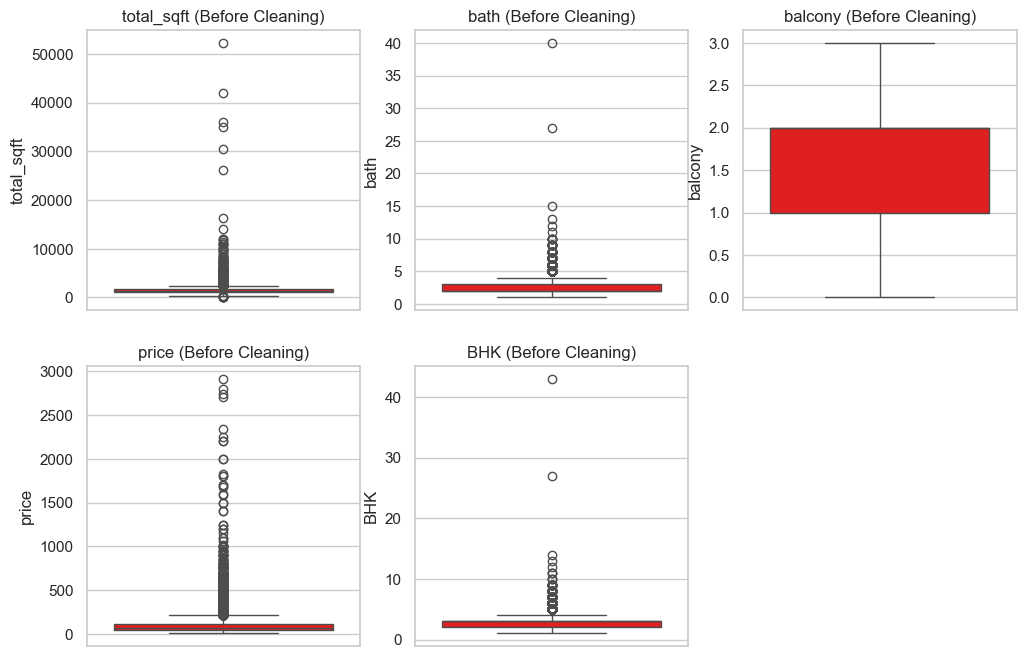

In [105]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=df,y=col, color='red')
    plt.title(f'{col} (Before Cleaning)')
    
plt.show()


In [106]:
print("Original shape: ",df.shape)

Original shape:  (12668, 7)


In [107]:
for col in features:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    lower_bound = q1-1.5*iqr
    upper_bound = q3+1.5*iqr
    df = df[(df[col]>=lower_bound) & (df[col]<=upper_bound)]  


print("Final shape of dataset after removing outliers from all numeric columns:", df.shape)

Final shape of dataset after removing outliers from all numeric columns: (10401, 7)


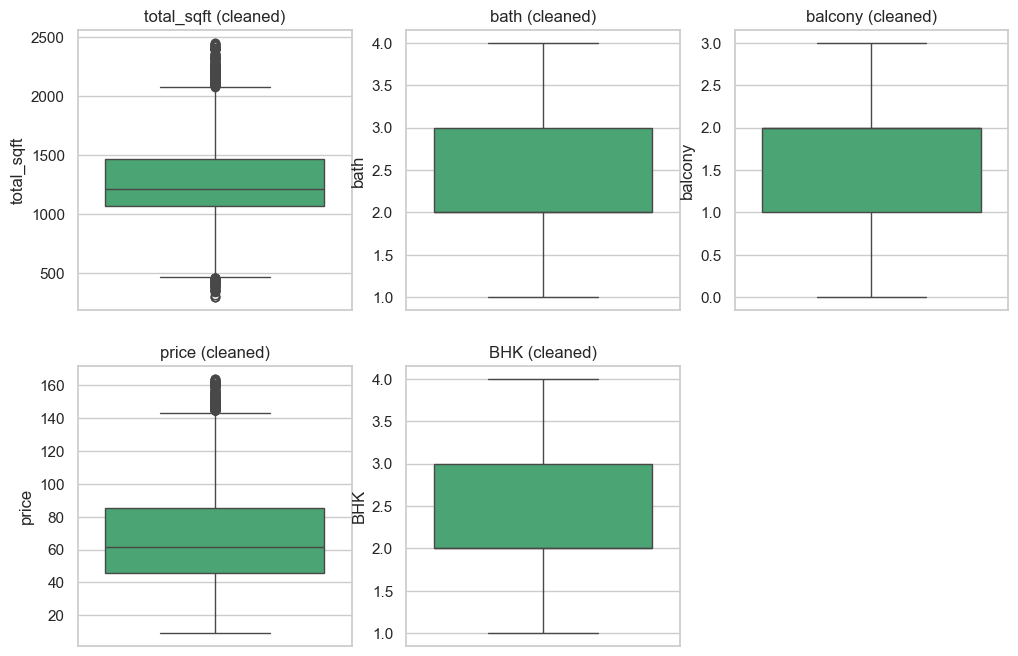

In [108]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col], color='mediumseagreen')
    plt.title(f'{col} (cleaned)')
    

plt.show()


## Feature Engineering


In [109]:
df.rename(columns={'price': 'price (in Lakhs)'}, inplace=True)


### Creating a new feature: price per square foot to standardize property prices

In [110]:

df['price_per_sqft'] = (df['price (in Lakhs)'] * 100000) / df['total_sqft']


In [111]:
df[['location', 'total_sqft', 'BHK', 'price (in Lakhs)', 'price_per_sqft']].head(10)


,location,total_sqft,BHK,price (in Lakhs),price_per_sqft
0,Electronic City Phase II,1056.0,2,39.07,3699.810606
2,Uttarahalli,1440.0,3,62.00,4305.555556
3,Lingadheeranahalli,1521.0,3,95.00,6245.890861
4,Kothanur,1200.0,2,51.00,4250.000000
5,Whitefield,1170.0,2,38.00,3247.863248
6,Marathahalli,1310.0,3,63.25,4828.244275
7,Whitefield,1800.0,3,70.00,3888.888889
9,7th Phase JP Nagar,1000.0,2,38.00,3800.000000
10,Gottigere,1100.0,2,40.00,3636.363636
11,Sarjapur,2250.0,3,148.00,6577.777778


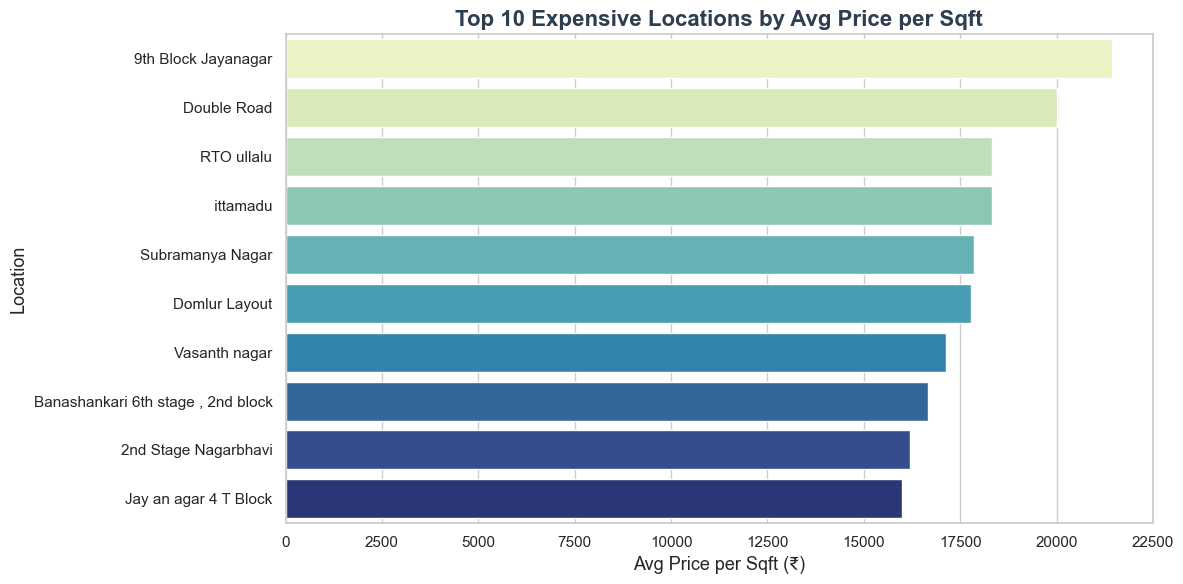

In [112]:
top_locations = df.groupby('location')['price_per_sqft'].mean().sort_values(ascending=False).head(10).reset_index()
sns.set(style="whitegrid", palette="pastel")

plt.figure(figsize=(12,6))
sns.barplot(data=top_locations, y='location', x='price_per_sqft', hue='location', dodge=False, palette='YlGnBu', legend=False)

plt.title('Top 10 Expensive Locations by Avg Price per Sqft', fontsize=16, fontweight='bold', color='#2c3e50')
plt.xlabel('Avg Price per Sqft (₹)', fontsize=13)
plt.ylabel('Location', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


### Adding feature: average square feet available per bedroom (BHK)

In [113]:
'''Here sqft_per_bhk is a proxy feature to estimate how spacious each bedroom might be.
While the total square footage includes other areas (kitchen, bathrooms, living), this feature helps identify outliers and distinguish between compact 
vs spacious homes.'''

'Here sqft_per_bhk is a proxy feature to estimate how spacious each bedroom might be.\nWhile the total square footage includes other areas (kitchen, bathrooms, living), this feature helps identify outliers and distinguish between compact \nvs spacious homes.'

In [114]:
df['sqft_per_bhk'] = df['total_sqft'] / df['BHK']
df = df[df['BHK'] != 0]  # Avoid division by zero
df[['total_sqft', 'BHK', 'sqft_per_bhk']].head()


,total_sqft,BHK,sqft_per_bhk
0,1056.0,2,528.0
2,1440.0,3,480.0
3,1521.0,3,507.0
4,1200.0,2,600.0
5,1170.0,2,585.0


### Encoding area_type using one-hot encoding to convert categorical data into numeric


In [115]:
df = pd.get_dummies(df, columns=['area_type'], drop_first=True)
df.columns[df.columns.str.contains('area_type')]

Index(['area_type_Carpet  Area', 'area_type_Plot  Area',
       'area_type_Super built-up  Area'],
      dtype='object')

In [116]:
df[['area_type_Carpet  Area', 'area_type_Plot  Area', 'area_type_Super built-up  Area']].head(10)


,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area
0,False,False,True
2,False,False,False
3,False,False,True
4,False,False,True
5,False,False,True
6,False,False,True
7,False,False,True
9,False,False,True
10,False,False,False
11,False,True,False


### Grouping rare locations under 'Other' to reduce dimensionality


In [117]:

df['location'].value_counts()


location
Whitefield         413
Sarjapur  Road     304
Electronic City    295
Kanakpura Road     250
Thanisandra        218
                  ... 
Rahmath Nagar        1
kadubisnahalli       1
Chamundi Nagar       1
Zuzuvadi             1
Chellikere           1
Name: count, Length: 1060, dtype: int64

In [118]:
location_stats = df['location'].value_counts()
rare_locations = location_stats[location_stats <= 10].index

df['location'] = df['location'].apply(lambda x: 'Other' if x in rare_locations else x)


### Encoding location using one-hot encoding


In [119]:
df = pd.get_dummies(df, columns=['location'], drop_first=True)


In [120]:
df.columns[df.columns.str.startswith('location_')]  # shows all encoded location columns


Index(['location_2nd Phase Judicial Layout', 'location_5th Phase JP Nagar',
       'location_6th Phase JP Nagar', 'location_7th Phase JP Nagar',
       'location_8th Phase JP Nagar', 'location_9th Phase JP Nagar',
       'location_AECS Layout', 'location_Abbigere', 'location_Akshaya Nagar',
       'location_Ambalipura',
       ...
       'location_Vasanthapura', 'location_Vidyaranyapura',
       'location_Vijayanagar', 'location_Vittasandra', 'location_Whitefield',
       'location_Yelachenahalli', 'location_Yelahanka',
       'location_Yelahanka New Town', 'location_Yelenahalli',
       'location_Yeshwanthpur'],
      dtype='object', length=192)

In [121]:
df.filter(like='location_').head()

,location_2nd Phase Judicial Layout,location_5th Phase JP Nagar,location_6th Phase JP Nagar,location_7th Phase JP Nagar,location_8th Phase JP Nagar,location_9th Phase JP Nagar,location_AECS Layout,location_Abbigere,location_Akshaya Nagar,location_Ambalipura,...,location_Vasanthapura,location_Vidyaranyapura,location_Vijayanagar,location_Vittasandra,location_Whitefield,location_Yelachenahalli,location_Yelahanka,location_Yelahanka New Town,location_Yelenahalli,location_Yeshwanthpur
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


# Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


In [2]:
df = pd.read_csv('/Users/hrituparnaghosh/Downloads/cleaned_bengaluru_house_data.csv')

In [3]:
df = df.select_dtypes(include=[np.number])

### Define Features and Target¶

In [4]:
X = df.drop('price', axis=1)
y = df['price']

### Train-Test Split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train Multiple Linear Regression Model

In [7]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)
y_pred = mlr.predict(X_test)
residuals = y_test - y_pred

### Coefficients

In [8]:
coeff_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": mlr.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

### Evaluation

In [9]:
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

### Actual vs predicted

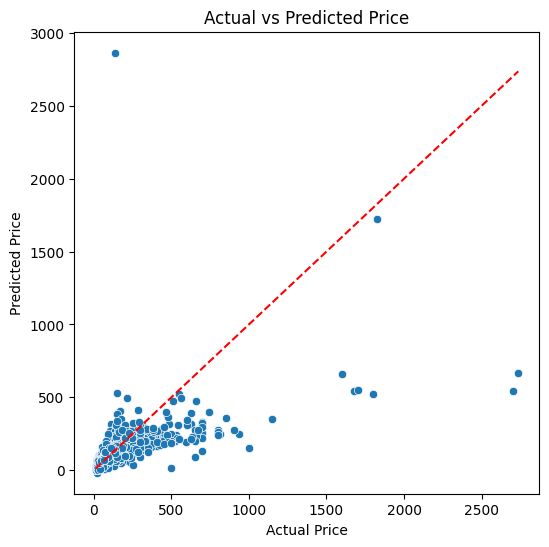

In [10]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
sns.lineplot(x=y_test, y=y_test, color='red', linestyle='--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.show()

### 